In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
import socket
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
# def running_mean(X,n=10):
#     return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
# #

In [3]:
n_cpus = 4
#print('** epoch: {}'.format(mpd.get_epoch()))


In [4]:
N_report_len = 180
end_dtm = dtm.datetime(2022,8,25)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)
print('*** dates: {} - {}'.format(start_date, end_date))
#partition='serc'
partition=None
group=None
s_user=None
verbose=0
# group='oneillm'
# group='edunham'
#s_user = 'labraha2'
#
sacct_h5_file = f'sacct_data/sacct_p{str(partition).upper()}_g{str(group).upper()}_u{s_user}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file [{os.path.isfile(sacct_h5_file)}]: {sacct_h5_file}')

*** dates: 2022-02-26 - 2022-08-25
*** sacct_h5_file [True]: sacct_data/sacct_pNONE_gNONE_uNone_20220226_20220825.h5


In [5]:
# NOTE: to get individual users, eg to get Eric's group usage:
#. sacct --allusers --user=labraha2 --start=2022-01-01 --end=2022-06-15
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=group, partition=partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose,
                                          end_date=str(end_date), keep_raw_data=False)
    # , sacct_user=s_user
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** Creating SACCT object from HDF5 sacct_data/sacct_pNONE_gNONE_uNone_20220226_20220825.h5
**  ('index', 'User', 'Group', 'GID', 'Account', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


In [6]:
#print('** ', SACCT_obj.format_list_default)
print('** ', SACCT_obj.jobs_summary.dtype.names)
for rw in SACCT_obj[0:10]:
    print(f'** {rw}')

**  ('index', 'User', 'Group', 'GID', 'Account', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')
** (0, b'nyusuf', b'users', b'100', b'suprib', b'case5', b'7867164', b'7867164', b'suprib', b'COMPLETED', 28., 1, 1, 738200.62172454, 738200.62172454, 738200.62172454, 738214.43212963, 13.81040509, 0.09627315, 13.03185185, 13.12813657, 1., b'1193219', b'00:00:00', b'billing=1,cpu=1,mem=1000M,node=1', b'billing=1,cpu=1,energy=193513277,mem=1000M,node=1', 3.355102e+10, 3.355102e+10, 3.6065512e+10, 3.6065512e+10, 1.746548e+11, 2.1735006e+11, 1.746548e+11, 2.1735006e+11, b'7867164', 0)
** (3, b'nyusuf', b'users', b'100', b'suprib', b'case17', b'7867176', b'7867176', b'suprib', b'COMP

In [7]:
# # check date epoch:
# dt_test = SACCT_obj.jobs_summary['Start'][0]
# yr_test = mpd.num2date(dt_test).year
# print(f'** yr_test: {yr_test}')
# #print('** ', mpd.num2epoch(dt_test))
# if yr_test>3000:
#     mpd.set_epoch('0000-12-31T00:00:00')
# yr_test = mpd.num2date(dt_test)
# print(f'** yr_test: {yr_test}')

In [8]:

print('** ', SACCT_obj.jobs_summary.dtype)
print('** ', type(SACCT_obj.jobs_summary['User'][0]))
#
my_ary = numpy.array(len(SACCT_obj.jobs_summary), dtype=SACCT_obj.jobs_summary.dtype)
print('** ', my_ary.dtype)
#
for cl,tp in SACCT_obj.jobs_summary.dtype.descr:
    print('** ', cl, tp)
    

print('** ** ', SACCT_obj.jobs_summary['Group'].astype(str)[0])


**  [('index', '<i8'), ('User', 'S8'), ('Group', 'S5'), ('GID', 'S3'), ('Account', 'S9'), ('JobName', 'S59'), ('JobID', 'S17'), ('JobIDRaw', 'S7'), ('Partition', 'S9'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S44'), ('AllocTRES', 'S60'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskRead', '<f8'), ('AveDiskWrite', '<f8'), ('AveDiskRead', '<f8'), ('JobID_parent', 'S17'), ('NGPUs', '<i8')]
**  <class 'numpy.bytes_'>
**  [('index', '<i8'), ('User', 'S8'), ('Group', 'S5'), ('GID', 'S3'), ('Account', 'S9'), ('JobName', 'S59'), ('JobID', 'S17'), ('JobIDRaw', 'S7'), ('Partition', 'S9'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'

*** DEBUG t_now: 738399.3486771297, t_max: 738391.9911921297


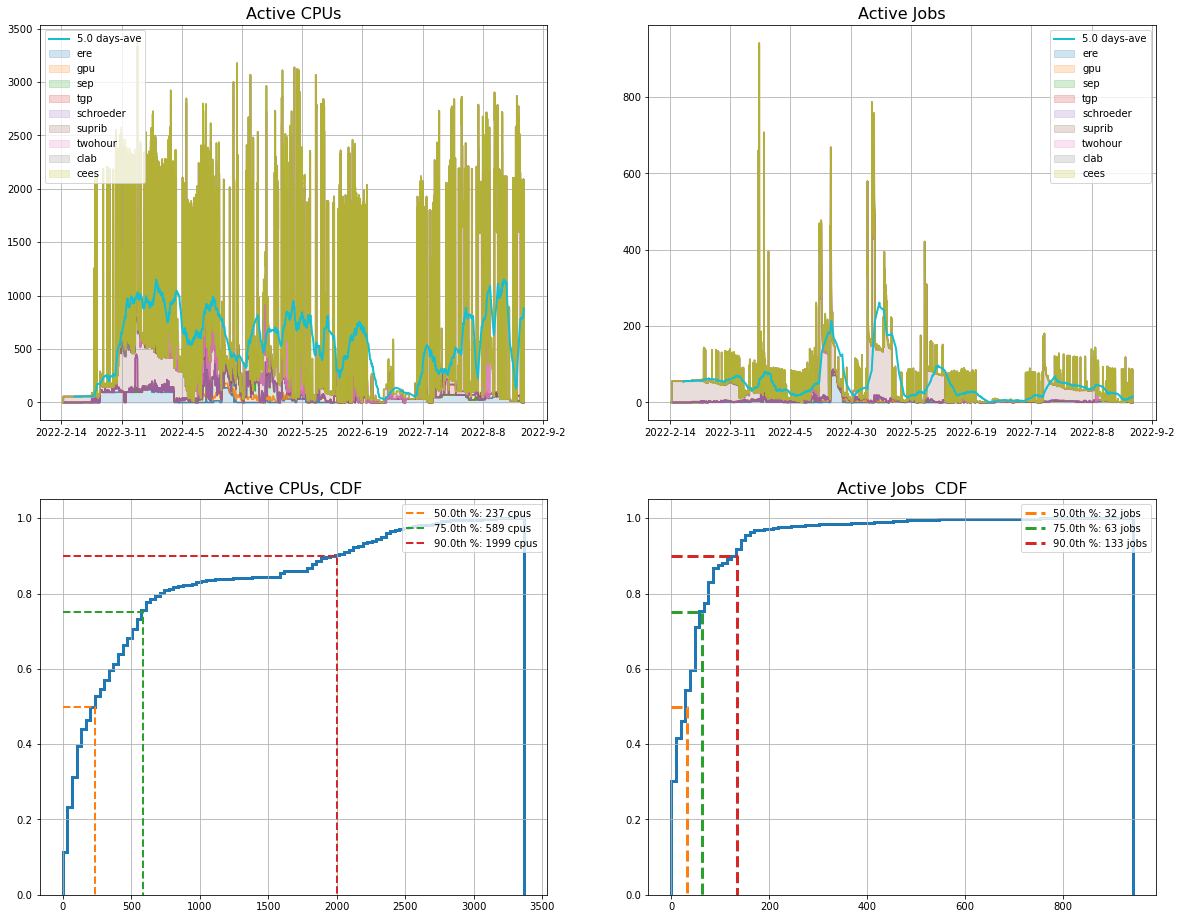

In [9]:
rep_cpu_lc = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(group_by='Partition')

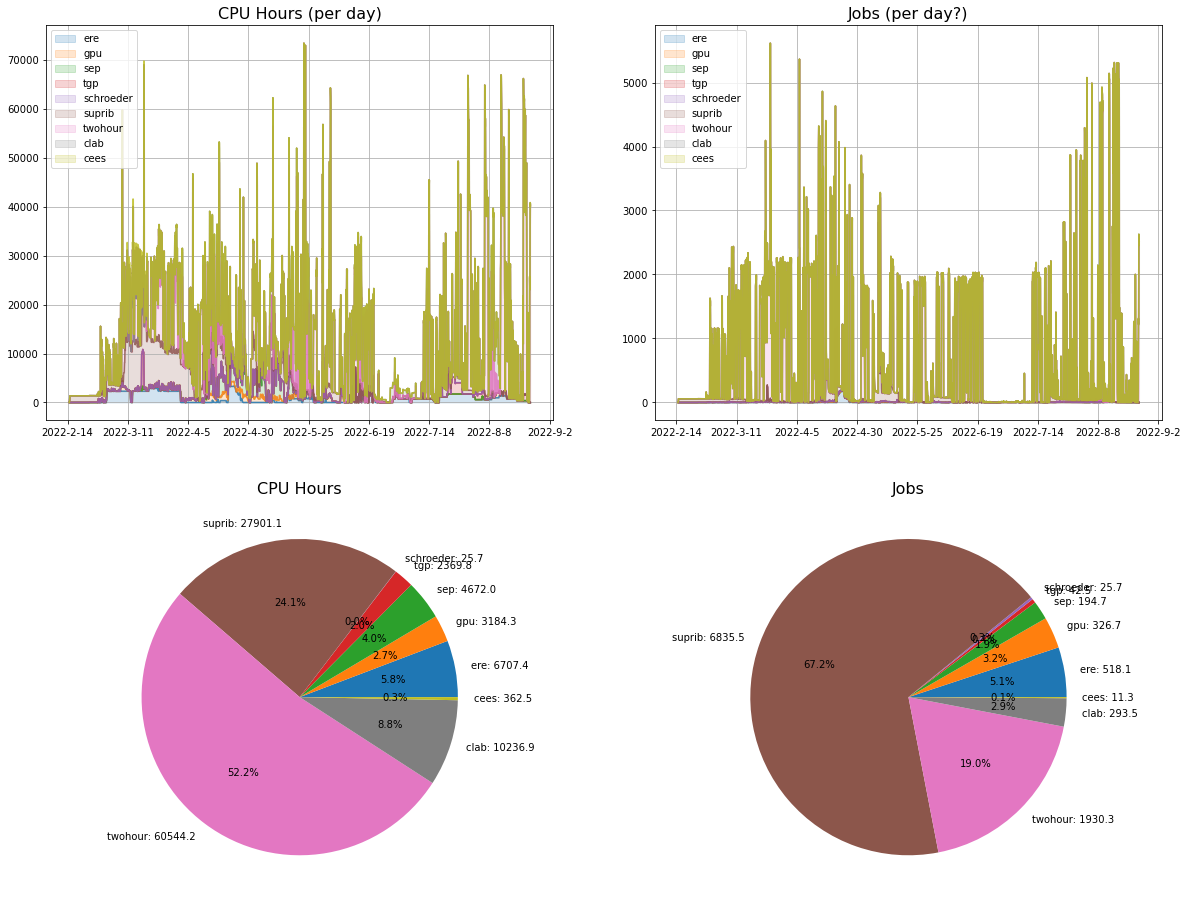

In [16]:
fg_cpuhlc = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='Partition', autopct='%1.1f%%')

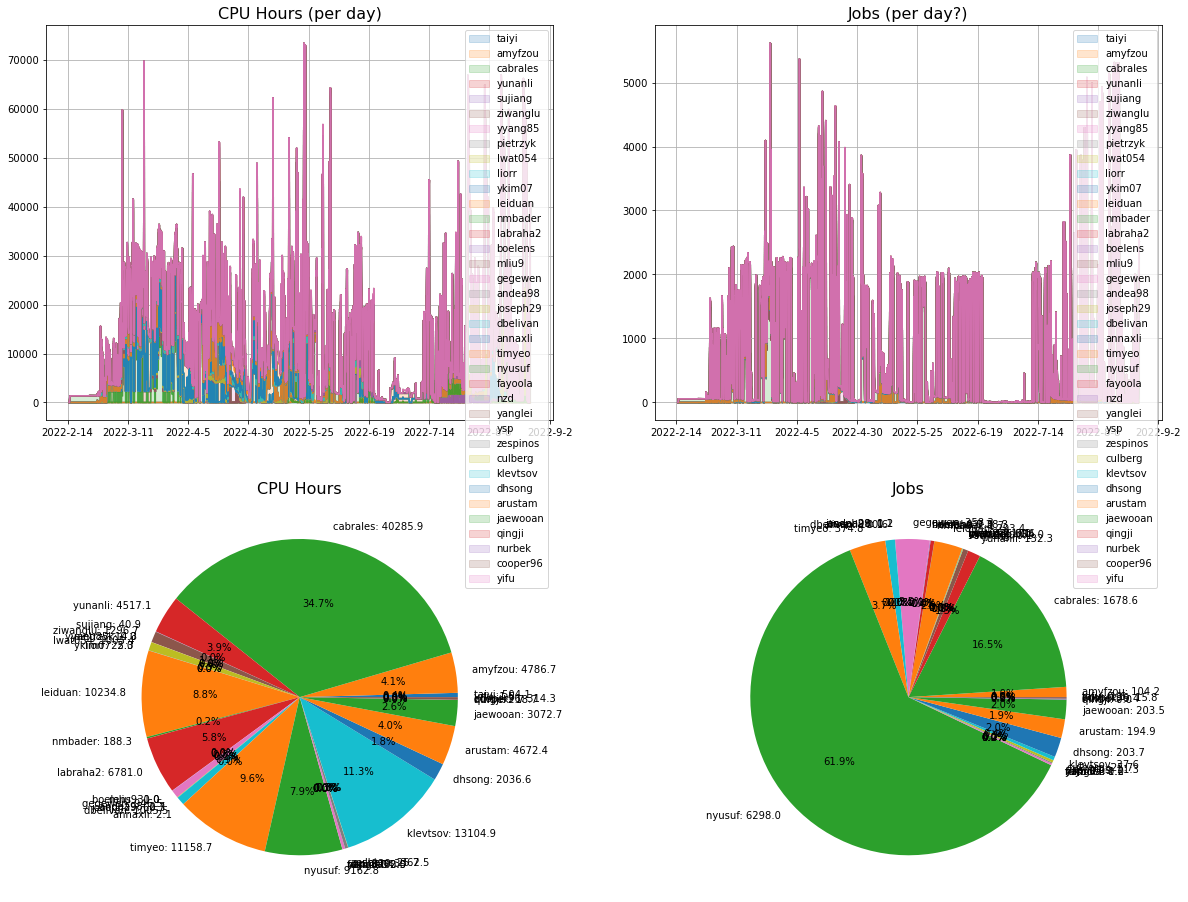

In [18]:
fg_cpuhl_u = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='User', autopct='%1.1f%%')

*** DEBUG t_now: 738399.3856169364, t_max: 738391.9911921297


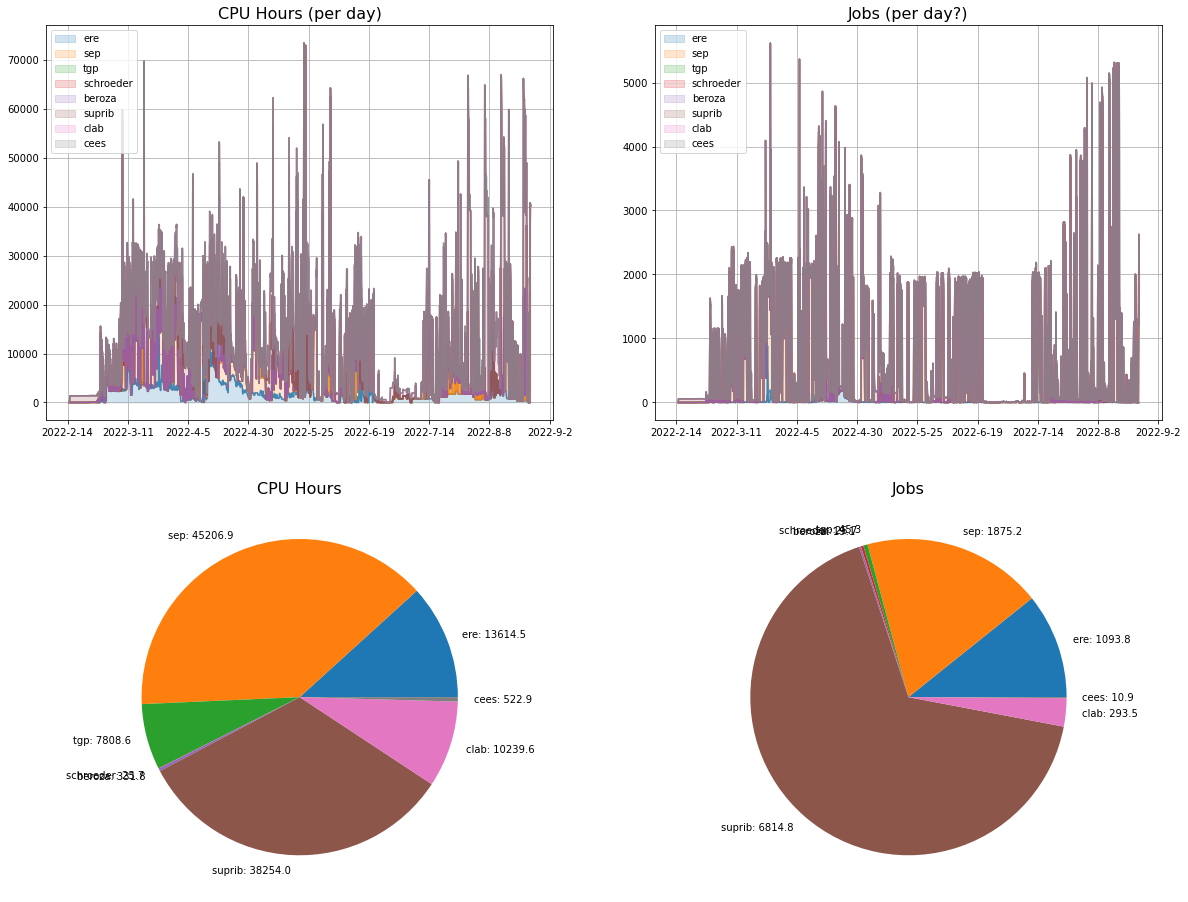

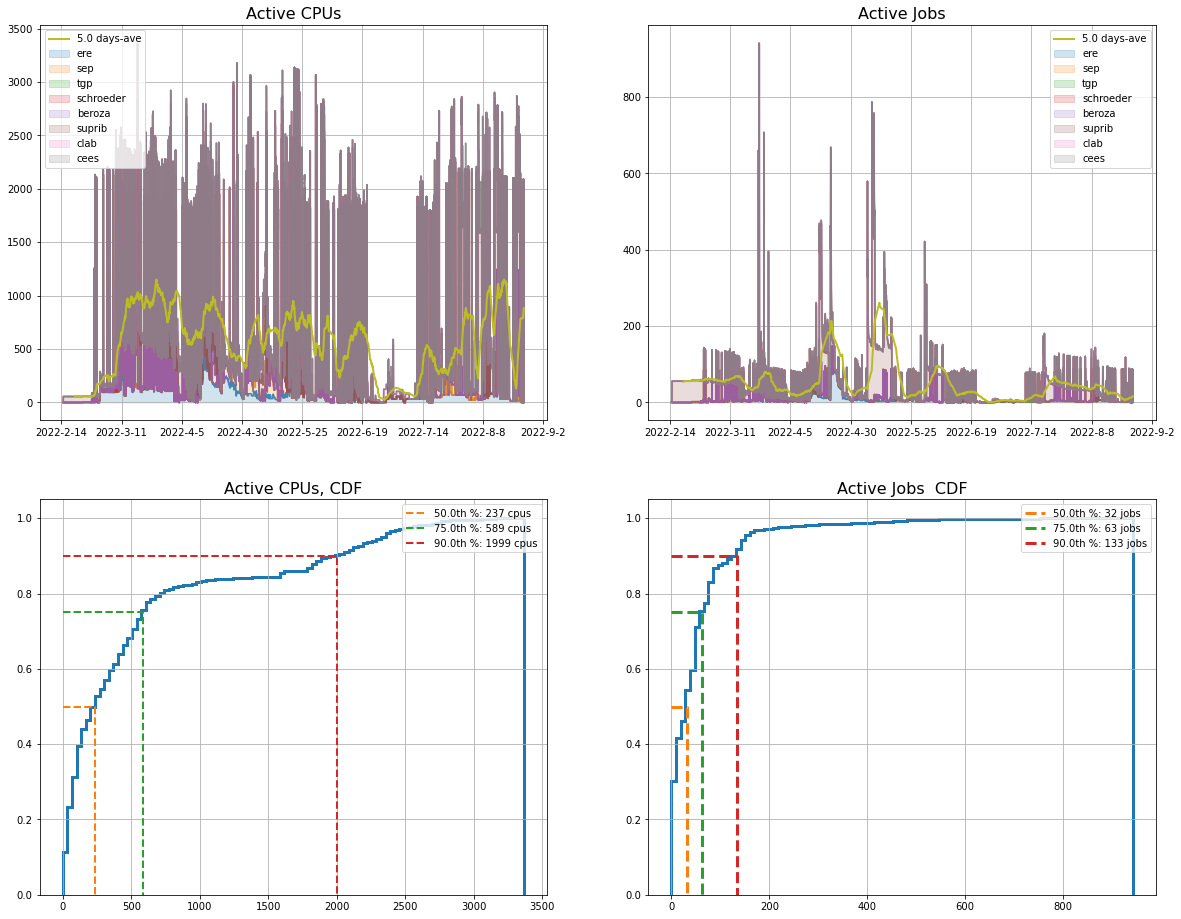

In [19]:
fg_cpuhl_acct = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='Account')
fg_cpu_lc_acct = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(group_by='Account')

*** DEBUG t_now: 738399.3501886046, t_max: 738391.9911921297


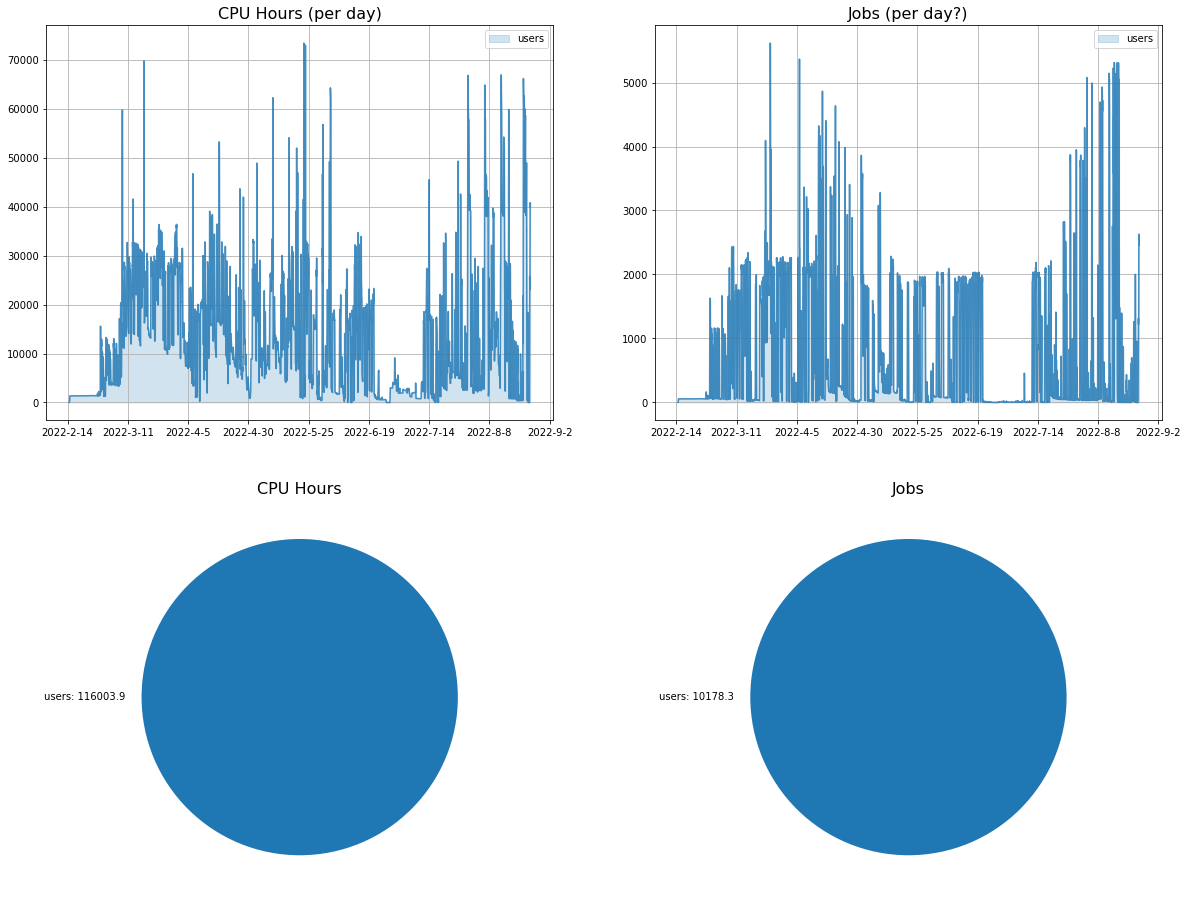

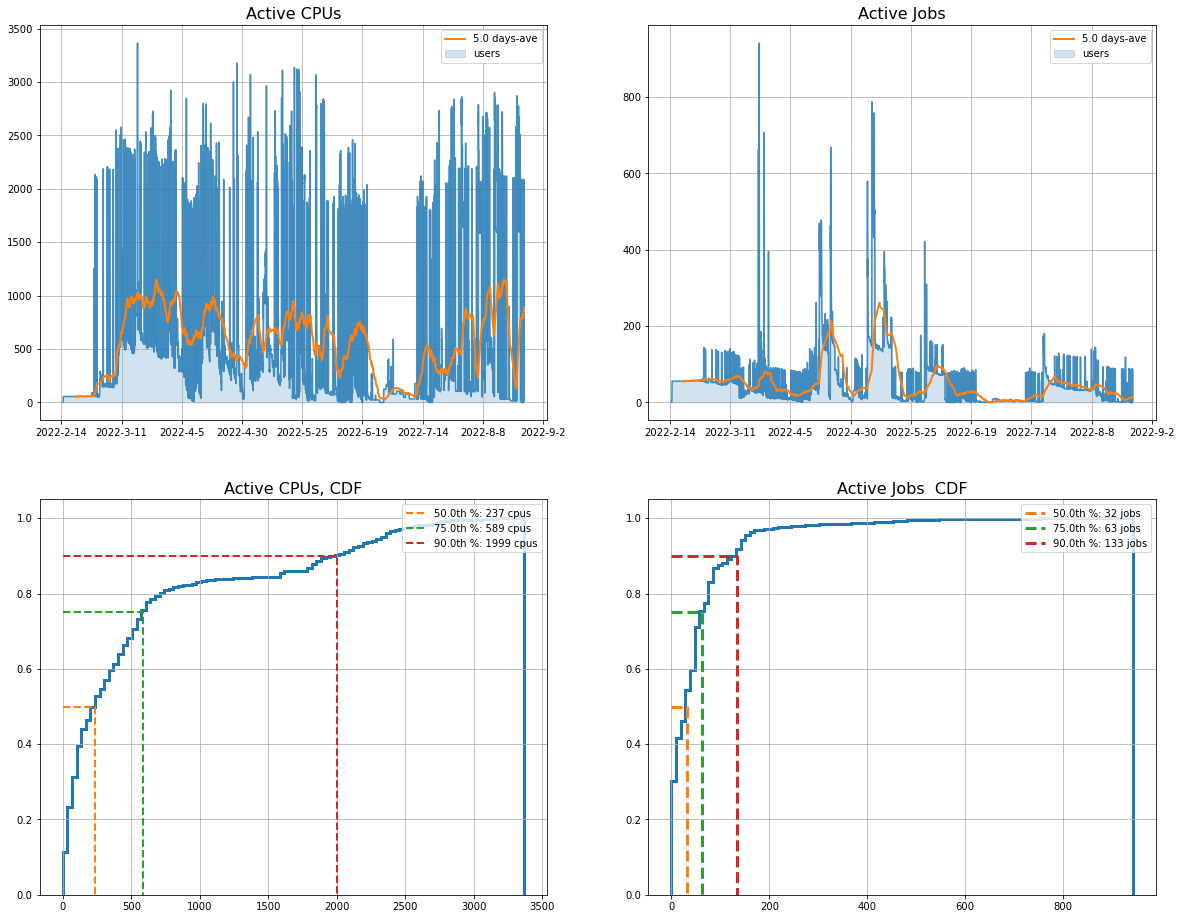

In [13]:
fg_cpuhl_acct = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='Group')
fg_cpu_lc_acct = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(group_by='Group')

In [15]:
print('** ', SACCT_obj.dtype.names)

**  ('index', 'User', 'Group', 'GID', 'Account', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


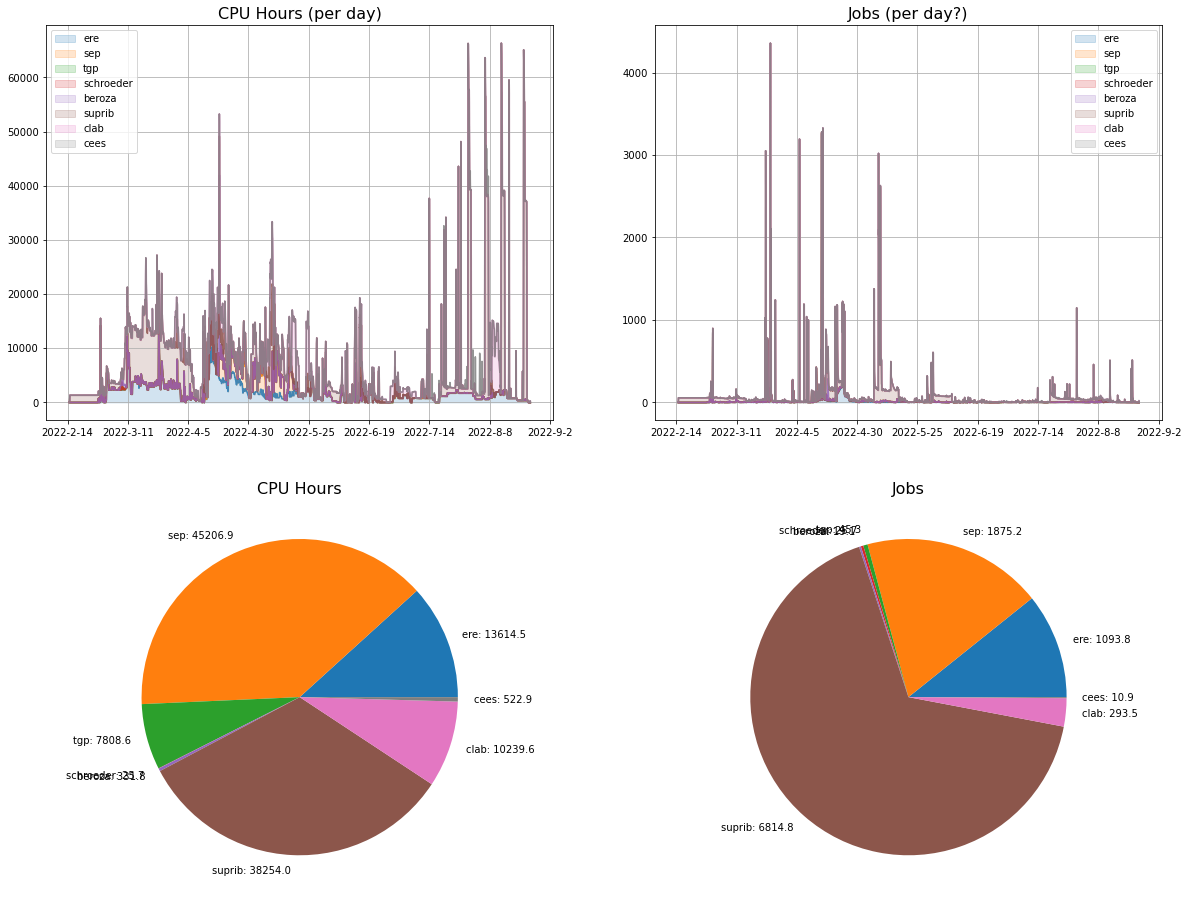

In [83]:
# A qick look at Accounts (or other breakout) with known inactive or graduated users removed.
ix_u = numpy.array([u not in ['cabrales', 'labraha2'] for u in SACCT_obj['User'].astype(str)])
fg_1 = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(group_by='Account', jobs_summary=SACCT_obj[ix_u])

### User stat table
- Generate a table of summary user stats

In [ ]:
#
cpuh_pie_user = hpc_lib.get_pie_slices(sum_data=SACCT_obj['Elapsed']*SACCT_obj['NCPUS'],
                                       slice_data=SACCT_obj['User'])
jobs_pie_user = hpc_lib.get_pie_slices(sum_data=SACCT_obj['Elapsed'], slice_data=SACCT_obj['User'])
#
t0 = mpd.date2num(start_date)
t1 = mpd.date2num(end_date)
delim = chr(9)
delim = ';'
print('*** CPU-hours: ')
#print('**  Name,   cpu-hours,    job-hours,  last_job_start', )
print(delim.join(['Name', 'cpu-hours', 'job-hours', 'n_jobs', 'last_job_start', 'Group', 'Accounts', 'Partitions']))
jindex = {nm:k for k,nm in enumerate(jobs_pie_user['name'])}
#print('** jindex: ', jindex)
for nm,n in cpuh_pie_user[numpy.argsort(cpuh_pie_user['value'])[::-1]]:
    ix = SACCT_obj['User'].astype(type(nm)) == nm
    fg = plt.figure(figsize=(10,4))
    ax = fg.add_subplot(1,1,1)
    z = SACCT_obj.get_cpu_hours(jobs_summary=SACCT_obj[ix])
    ax.plot(z['time'], z['cpu_hours'], ls='-', marker='')
    ax.set_xlim(t0,t1)
    ax.grid()
    ax.set_title(nm.decode(), size=16)
    #
    fg.canvas.draw()
    dt_epoch = hpc_lib.compute_mpd_epoch_dt(z['time'][0])
    lbls = [hpc_lib.simple_date_string(mpd.num2date(x + dt_epoch)) for x in ax.get_xticks()]
#     lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_value()))) + dt_epoch) )
#               for s in ax.get_xticklabels()]

    #
    ax.set_xticklabels(lbls)
    #
    rw_vals = [nm.decode(), n, jobs_pie_user['value'][jindex[nm]], numpy.sum(ix).astype(int),\
          mpd.num2date(max(SACCT_obj['Start'][ix])), SACCT_obj['Group'][ix].astype(str)[0],\
                ','.join(numpy.unique(SACCT_obj['Account'][ix]).astype(str)),\
                ','.join(numpy.unique(SACCT_obj['Partition'][ix]).astype(str))]
    print(delim.join([str(x) for x in rw_vals]))
#     print(f"{nm.decode()}, {n}, {jobs_pie_user['value'][jindex[nm]]},\
#           {mpd.num2date(max(SACCT_obj['Start'][ix]))}, {SACCT_obj['Group'][ix].astype(str)[0]},\
#                 {delim.join(numpy.unique(SACCT_obj['Account'][ix]).astype(str))},\
#                 {delim.join(numpy.unique(SACCT_obj['Partition'][ix]).astype(str))}\
#                 ")
#
# print('*** Jobs-time:')
# print('**  Name,   n_jobs,   last_job_start')
# for nm,n in jobs_pie_user[numpy.argsort(jobs_pie_user['value'])[::-1]]:
#     ix = SACCT_obj['User'].astype(type(nm)) == nm
#     print(f"**  {nm.decode()}, {n}, {mpd.num2date(max(SACCT_obj['Start'][ix]))}, {SACCT_obj['Group'][ix][0]}")

*** CPU-hours: 
Name;cpu-hours;job-hours;n_jobs;last_job_start;Group;Accounts;Partitions


In [79]:
print('** ', ax)
print('** ', ax.get_xticklabels()[0].get_position()[0])
print('** ', ax.get_xticks())

**  AxesSubplot(0.125,0.125;0.775x0.755)
**  738200.0
**  [738200. 738225. 738250. 738275. 738300. 738325. 738350. 738375. 738400.
 738425.]


In [ ]:
print('** ', cpuh_pie_user.dtype)

NameError: name 'cpu_hrs_jobs' is not defined

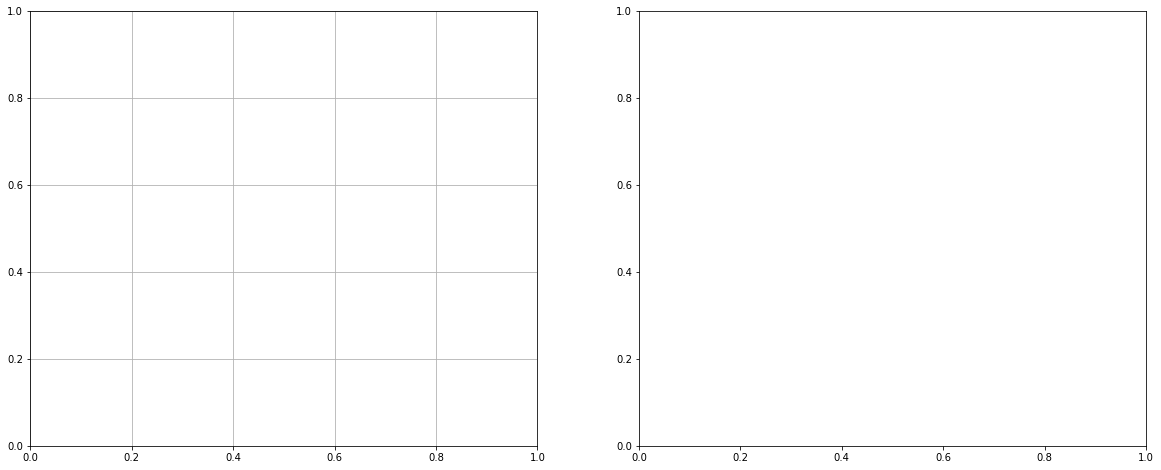

In [25]:
fg = plt.figure(figsize=(20,8))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
ax1.grid()
#
N_max = float(130*24*24)
#
cpuh = next(iter(cpu_hrs_jobs.values()))
z = numpy.zeros(len(cpuh['cpu_hours']))
X = cpuh['cpu_hours']['time']
dX = X[1]-X[0]
#
elapsed = {}

for pt,vls in cpu_hrs_jobs.items():
#     if vls['elapsed'] == 0.:
#         continue
    #print('*** {}: {}'.format(pt, vls.keys()))
    #
    elapsed[pt]=vls['elapsed']
    #
    z_prev = z.copy()
    dz = vls['cpu_hours']['cpu_hours']
    print('*** {}: sum(dz): {}'.format(pt, dX*numpy.sum(dz)/cpuh_bin))
    z += dz
    ln, = ax1.plot(X, z, label=pt)
    clr = ln.get_color()
    ax1.fill_between(X, z_prev, z, color=clr, alpha=.2)
    #
    #ax1.fill_between(X, z_prev, z, alpha=.2)

ax1.plot(X[0::len(X)-1], numpy.ones(2)*N_max, ls='--', lw=3.)
ax1.legend(loc=0)
#
# fg.canvas.draw()
# print('*** ax1.get_xticklabels(): ', [s.get_text() for s in ax1.get_xticklabels()])

# lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text())))) ) 
#          for s in ax1.get_xticklabels()]
# print('*** ', [s for s in ax1.get_xticklabels()])
# print('*** ', [s.get_position()[0] for s in ax1.get_xticklabels()])
# ax1.set_xticklabels(lbls)
# fg.canvas.draw()
#
pi_lbls, pi_vls = zip(*list(elapsed.items()))
pi_lbls = [f'{lbl}: {24.*x/1000:.1f}k' for lbl,x in zip(pi_lbls, pi_vls)]
ax2.pie(pi_vls, labels=pi_lbls)
#
for ky,vl in elapsed.items():
    print(f'{ky}: {vl*24.} cpu-hrs')
    

In [11]:
print('** ', numpy.sum([x for x in elapsed.values()])*24.)


**  3041210.7661111113


In [12]:
print('*** ', numpy.min(SACCT_obj.jobs_summary['Start']) , numpy.min(SACCT_obj.jobs_summary['End']))

***  738123.0626388888 738146.0021759259


In [13]:
# Now, let's get a some reports for specific users, namely Lauren and Eric's former student(s) to estimate
#. requirements for their successors.
#
# Also, TODO: layer cake for active_cpus ?
# NOTE: for up and coming "how busy is the queue?" reporting, something like this:
# squeue -p serc --Format=jobid,jobarrayid,partition,username,state,timeused,timeleft,allocnodes,numnodes,numcpus


In [14]:
cpuh_jobs = SACCT_obj.get_cpu_hours(bin_size=1., n_points=5000)

In [15]:
cpuh_layers = SACCT_obj.get_cpu_hours_layer_cake(bin_size=1.)

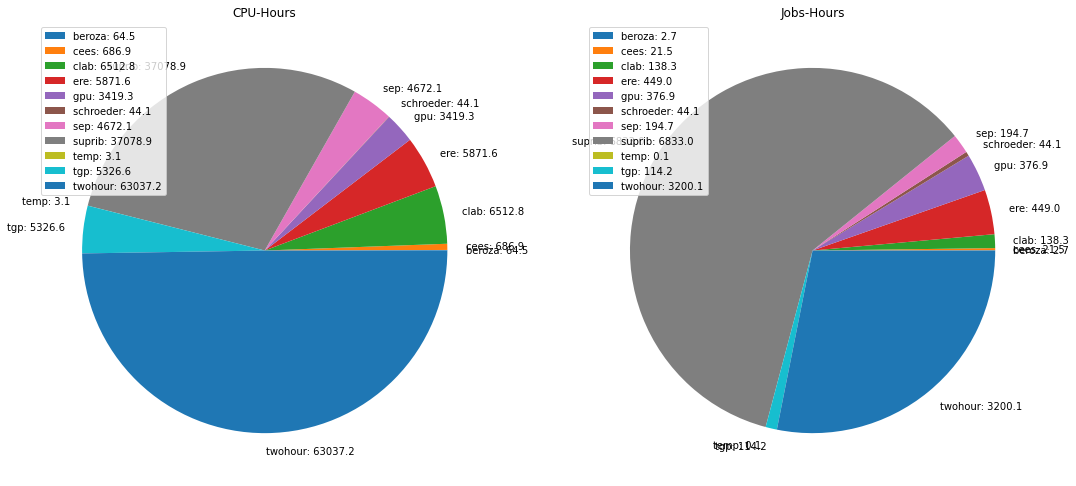

In [213]:


#
#pi_slices = hpc_lib.get_pie_slices(SACCT_obj.jobs_summary['Elapsed'], SACCT_obj.jobs_summary['Partition'])
fg = plt.figure(figsize=(18,10))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
#
ax1.set_title('CPU-Hours')
ax2.set_title('Jobs-Hours')
#
pie_cpuh_data = hpc_lib.plot_pie(sum_data=SACCT_obj.jobs_summary['Elapsed']*SACCT_obj.jobs_summary['NCPUS'],
                                slice_data=SACCT_obj.jobs_summary['Partition'], 
                            ax=ax1
                                )
#pi_slices = ax.pie(pi_slices[:,1], labels=pi_slices[:,0])
pie_jobs_data = hpc_lib.plot_pie(sum_data=SACCT_obj.jobs_summary['Elapsed'], 
                            slice_data=SACCT_obj.jobs_summary['Partition'], 
                            ax=ax2)
ax1.legend(loc=0)
ax2.legend(loc=0)



***  [('time', '>f8'), ('ere', '>f8'), ('schroeder', '>f8'), ('temp', '>f8'), ('sep', '>f8'), ('gpu', '>f8'), ('cees', '>f8'), ('suprib', '>f8'), ('clab', '>f8'), ('beroza', '>f8'), ('tgp', '>f8'), ('twohour', '>f8')]
***  [738146.00162037 738146.03762724 738146.07363412 738146.10964099
 738146.14564786 738146.18165473 738146.21766161 738146.25366848
 738146.28967535 738146.32568222]
***  [   0.          452.72665939  897.0199886  1319.77332522 1762.92665398
 2192.19575027 2613.86557073 2947.09539085 3376.58664968 3820.72665377]


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:2992: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:2992: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


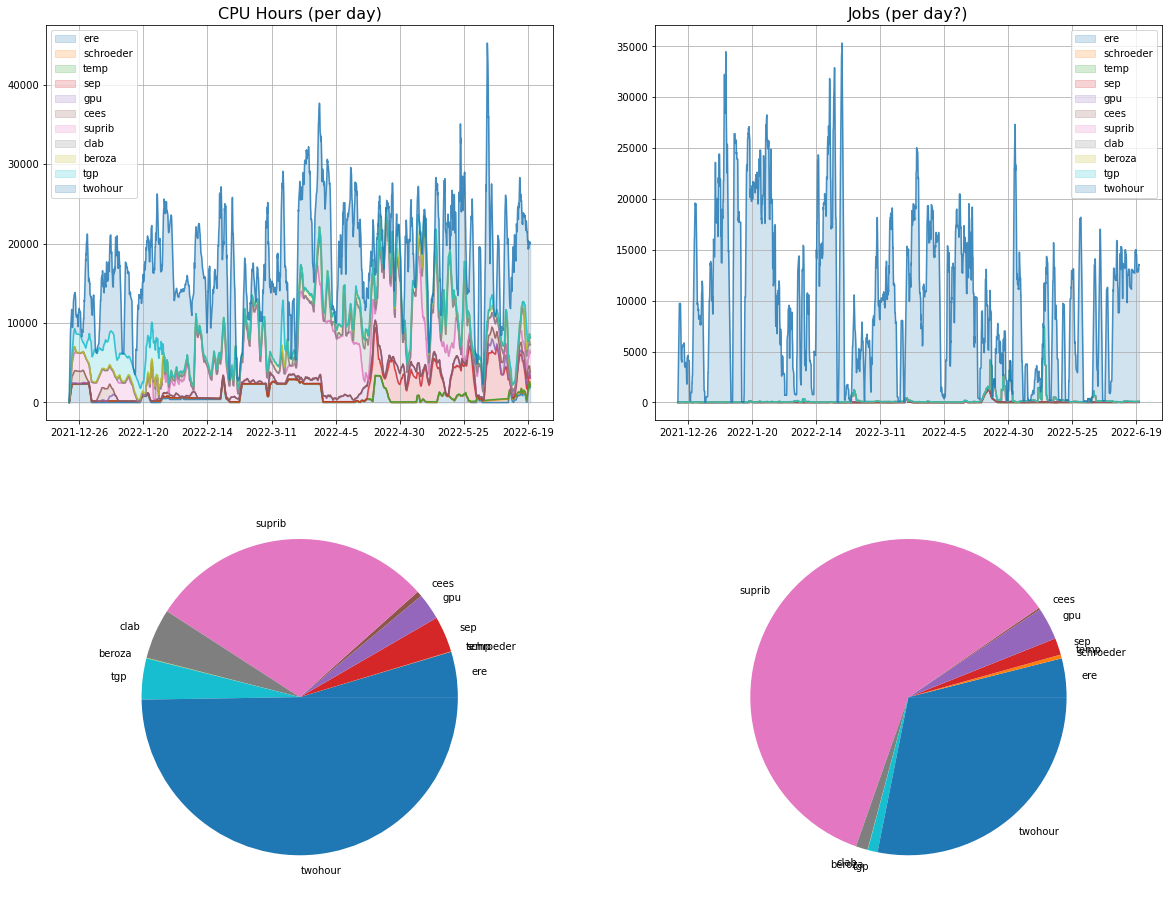

In [161]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('CPU Hours (per day)', size=16)
ax2.set_title('Jobs (per day?)', size=16)
#
cpuh = cpuh_layers['cpu_hours']
jobs = cpuh_layers['jobs']
T = cpuh['time']

print('*** ', cpuh.dtype)
print('*** ', cpuh['time'][0:10])
print('*** ', cpuh['twohour'][0:10])
#
z_cpuh = hpc_lib.plot_layer_cake(data=cpuh, layers=cpuh.dtype.names[1:], time_col='time', ax=ax1)
z_jobs = hpc_lib.plot_layer_cake(data=jobs, layers=cpuh.dtype.names[1:], time_col='time', ax=ax2)
#
# pi charts. left: cpu-hours, right job-time
pi_cpuh_lbls, pi_cpuh_vls = zip(*list(cpuh_layers['elapsed'].items()))
#pi_jobs_lbls, pi_jobs_vls = zip(*list({ky:numpy.sum(SACCT_obj.jobs_summary['Elapsed'][SACCT_obj.jobs_summary['Partition']==ky.encode()]) for ky in cpuh.dtype.names[1:]}.items()))
pi_jobs_lbls, pi_jobs_vls = get_pie_slices(data=SACCT_obj.jobs_summary, col_sum='Elapsed', col_slices=)
#
ax3.pie(pi_cpuh_vls, labels=pi_cpuh_lbls)
ax4.pie(pi_jobs_vls, labels=pi_jobs_lbls)
#
ax1.legend(loc=0)
ax2.legend(loc=0)
#
# fg.canvas.draw()
# for ax in (ax1, ax2):
#     lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) + SACCT_obj.dt_mpd_epoch ) ) 
#              for s in ax.get_xticklabels()]
#     ax.set_xticklabels(lbls)
#fg.canvas.draw()
#lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text())))) ) 
#         for s in ax1.get_xticklabels()]
#ax1.set_xticklabels(lbls)


In [18]:
pi_cpuh_vls, pi_cpuh_lbls = zip(*list(cpuh_layers['elapsed'].items()))
pi_jobs_vls, pi_jobs_lbls = zip(*list({ky:numpy.sum(SACCT_obj.jobs_summary['Elapsed'][SACCT_obj.jobs_summary['Partition']==ky.encode()]) for ky in cpuh.dtype.names[1:]}.items()))

In [19]:
print('** ', pi_cpuh_vls, pi_cpuh_lbls)
print('** ', pi_jobs_vls, pi_jobs_lbls)

**  ('ere', 'schroeder', 'temp', 'sep', 'gpu', 'cees', 'suprib', 'clab', 'beroza', 'tgp', 'twohour') (5871.606608796295, 44.13430555555556, 3.1163888888888884, 4672.060277777778, 3419.2856481481476, 686.9180555555555, 37078.92037037037, 6512.814814814816, 64.46388888888889, 5326.631145833331, 63037.16375000001)
**  ('ere', 'schroeder', 'temp', 'sep', 'gpu', 'cees', 'suprib', 'clab', 'beroza', 'tgp', 'twohour') (449.0079513888889, 44.13430555555556, 0.12984953703703703, 194.67011574074073, 376.92251157407406, 21.476493055555554, 6833.0237847222215, 138.29057870370372, 2.68599537037037, 114.15144675925927, 3200.0945601851863)


In [20]:
jobs_cpu = SACCT_obj.active_jobs_cpu(n_points=5000, bin_size=None, t_min=None, t_max=None, t_now=None, n_cpu=None, 
                                     jobs_summary=None, verbose=None, mpp_chunksize=10000, nan_to=0.)


*** DEBUG: 5000, None


In [202]:
sb = b'astring'
print('** ', sb, str(sb), bytes.decode(sb))

Sb = numpy.array([b'Sb1', b'Sb2', b'Sb3'])
S = numpy.array(['S1', 'S2', 'S3'])
print('* *: ', S, S.astype(str))
print('** [{}] :: [{}]'.format(S.dtype, Sb.dtype))
print('** ', S.astype(bytes), S.astype(bytes).dtype, S.dtype)
print('** ', isinstance('abc', type('def')))

print('*** ***: ', numpy.array(S.astype(Sb.dtype)))
#
n_f = 2
x = numpy.random.random()
print(f'** x: {x}, {x:.2f}, {x:.{n_f}f}')

**  b'astring' b'astring' astring
* *:  ['S1' 'S2' 'S3'] ['S1' 'S2' 'S3']
** [<U2] :: [|S3]
**  [b'S1' b'S2' b'S3'] |S2 <U2
**  True
*** ***:  [b'S1' b'S2' b'S3']
** x: 0.7395994798225949, 0.74, 0.74


In [197]:
acpu_layer_cake = SACCT_obj.get_active_cpus_layer_cake(layer_field='Partition')

*** DEBUG: 5000, None
*** DEBUG: 5000, None
** ** **: t_start, t_end:  [738162.09887731] [738162.22872685]
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None


In [154]:
dt_ep = hpc_lib.compute_mpd_epoch_dt(738150)
print('** ', dt_ep)
print('** ', SACCT_obj.compute_mpd_epoch_dt())
print('** *', hpc_lib.compute_mpd_epoch_dt(dtm.datetime.now()))
#
#print('** ', isinstance(numpy.datetime64(dtm.datetime.now())) )

**  -719163.0
**  -719163.0
** * 0.0


***  [('time', '>f8'), ('ere', '>f8'), ('schroeder', '>f8'), ('temp', '>f8'), ('sep', '>f8'), ('gpu', '>f8'), ('cees', '>f8'), ('suprib', '>f8'), ('clab', '>f8'), ('beroza', '>f8'), ('tgp', '>f8'), ('twohour', '>f8')]
***  [738146.00162037 738146.03762724 738146.07363412 738146.10964099
 738146.14564786 738146.18165473 738146.21766161 738146.25366848
 738146.28967535 738146.32568222]
***  [1512.    0.    0.    0.    0. 2040. 2040. 2040.    0.    0.]


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:2992: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:2992: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


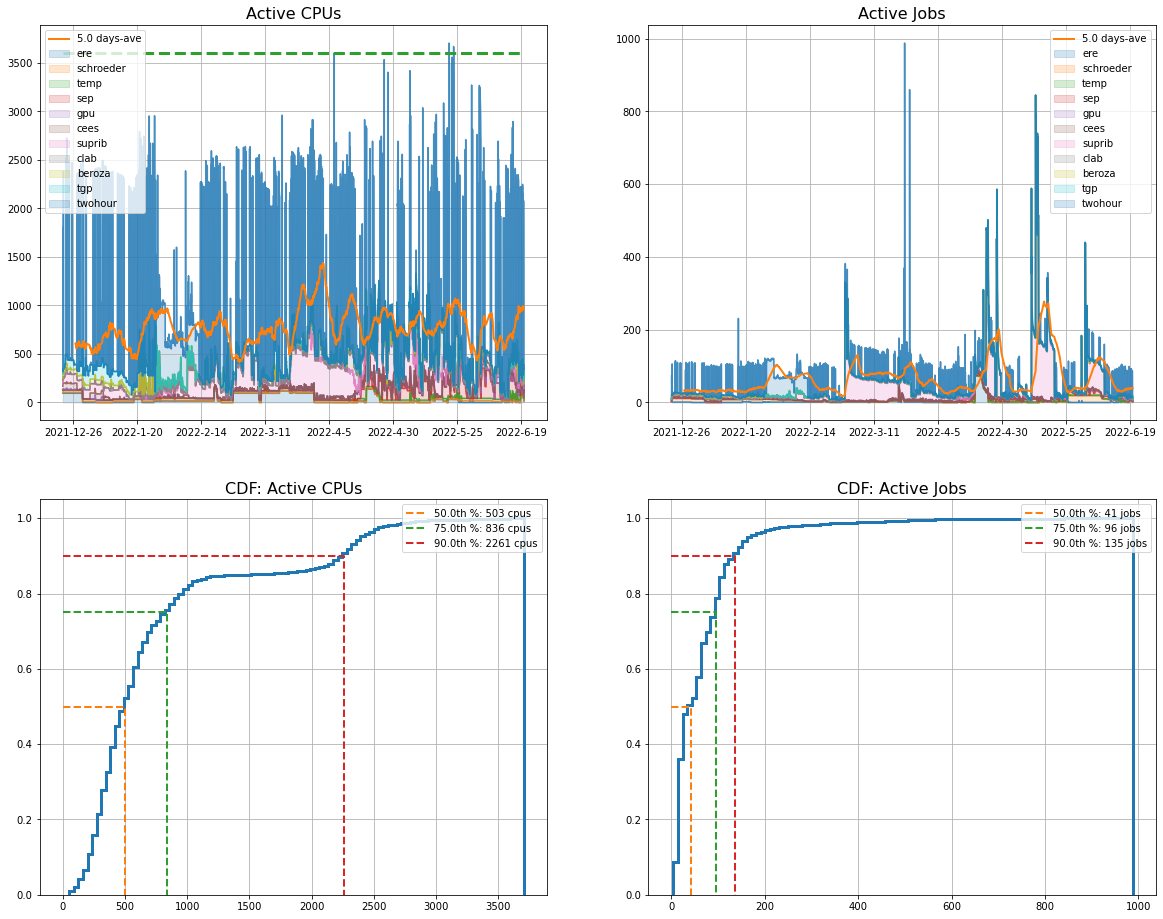

In [158]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('Active CPUs', size=16)
ax2.set_title('Active Jobs', size=16)
ax3.set_title('CDF: Active CPUs', size=16)
ax4.set_title('CDF: Active Jobs', size=16)
#
cpus = acpu_layer_cake['N_cpu']
jobs = acpu_layer_cake['N_jobs']
T = cpus['time']
N_max = 150*24.
#
print('*** ', cpus.dtype)
print('*** ', cpus['time'][0:10])
print('*** ', cpus['twohour'][0:10])
#
hpc_lib.plot_layer_cake(data=acpu_layer_cake['N_cpu'], ax=ax1)
hpc_lib.plot_layer_cake(data=acpu_layer_cake['N_jobs'], ax=ax2)
#
# z_cpus = numpy.zeros(len(cpus))
# z_jobs = numpy.zeros(len(jobs))
# for lyr in cpus.dtype.names:
#     if lyr == 'time':
#         continue
#     #
#     z_cpus_prev = z_cpus.copy()
#     z_jobs_prev = z_jobs.copy()
#     dz_cpus = cpus[lyr]
#     dz_jobs = jobs[lyr]
#     #
#     z_cpus += dz_cpus
#     z_jobs += dz_jobs
#     #
#     ln_cpus, = ax1.plot(T, z_cpus, ls='-', alpha=.8)
#     clr = ln_cpus.get_color()
#     ax1.fill_between(T, z_cpus_prev, z_cpus, color=clr, alpha=.2, label=lyr)
#     #
#     ln_jobs, = ax2.plot(T, z_jobs, ls='-', alpha=.8)
#     clr = ln_jobs.get_color()
#     ax2.fill_between(T, z_jobs_prev, z_jobs, color=clr, alpha=.2, label=lyr)
#
# get an ave-len of about a day...
n_days=5.
ave_len = int(numpy.ceil(n_days*len(T)/(T[-1] - T[0])))
#z_cpus = acpu_layer_cake['N_cpu'].dtype.names
z_cpu = ax1.get_lines()[-1].get_ydata()
z_jobs = ax2.get_lines()[-1].get_ydata()
z_cpus_smooth = hpc_lib.running_mean(z_cpu, ave_len)
z_jobs_smooth = hpc_lib.running_mean(z_jobs, ave_len)
#
ax1.plot(T[-len(z_cpus_smooth):], z_cpus_smooth, ls='-', marker='', lw=2, label=f'{n_days} days-ave')
ax2.plot(T[-len(z_jobs_smooth):], z_jobs_smooth, ls='-', marker='', lw=2, label=f'{n_days} days-ave')
#
# # pi charts. left: cpu-hours, right job-time
def f_ix(ky, sacct_obj):
    return [sacct_obj.jobs_summary['Partition']==ky.encode()]
#
# Pie charts aren't really 
# pi_cpus_lbls, pi_cpus_vls = zip(*list({ky:numpy.sum(SACCT_obj.jobs_summary['Elapsed'][f_ix(ky, SACCT_obj)]*SACCT_obj.jobs_summary['NCPUS'][f_ix(ky, SACCT_obj)]) for ky in cpuh.dtype.names[1:]}.items()))
# pi_jobs_lbls, pi_jobs_vls = zip(*list({ky:numpy.sum(SACCT_obj.jobs_summary['Elapsed'][SACCT_obj.jobs_summary['Partition']==ky.encode()]) for ky in cpuh.dtype.names[1:]}.items()))
# # #
# ax3.pie(pi_cpus_vls, labels=pi_cpus_lbls)
# ax4.pie(pi_jobs_vls, labels=pi_jobs_lbls)
#
qs = numpy.array([.5, .75, .9])
qs_cpus = numpy.quantile(z_cpu, qs)
qs_jobs = numpy.quantile(z_jobs, qs)
#
hh_cpus = ax3.hist(z_cpu, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_cpus, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} cpus' )
#
hh_jobs = ax4.hist(z_jobs, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_jobs, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax4.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} jobs' )



#
ax1.plot(T[0::len(T)-1], numpy.ones(2)*N_max, ls='--', lw=3.0  )
#
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax4.legend(loc=0)
#
ax3.grid()
ax4.grid()

# fg.canvas.draw()
# for ax in (ax1, ax2):
#     lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text())))) ) 
#              for s in ax.get_xticklabels()]
#     ax.set_xticklabels(lbls)
# fg.canvas.draw()



In [26]:
print('*** ', mpd.num2date(738150))
print('*** ', mpd.date2num(dtm.datetime(2022,1,1)))
print('*** ', 3600/24)
#
print('** ', SACCT_obj.jobs_summary.dtype.descr)
print('** cpu_hours capacity: ', 350*24*24)
print('** quantiles_cpu: ', qs_cpus)

***  3990-12-27 00:00:00+00:00
***  18993.0
***  150.0
**  [('index', '<i8'), ('User', ('|S8', {'h5py_encoding': 'ascii'})), ('Group', ('|S5', {'h5py_encoding': 'ascii'})), ('GID', ('|S3', {'h5py_encoding': 'ascii'})), ('JobName', ('|S29', {'h5py_encoding': 'ascii'})), ('JobID', ('|S20', {'h5py_encoding': 'ascii'})), ('JobIDRaw', ('|S7', {'h5py_encoding': 'ascii'})), ('Partition', ('|S9', {'h5py_encoding': 'ascii'})), ('State', ('|S19', {'h5py_encoding': 'ascii'})), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', ('|S9', {'h5py_encoding': 'ascii'})), ('Suspended', ('|S8', {'h5py_encoding': 'ascii'})), ('ReqTRES', ('|S44', {'h5py_encoding': 'ascii'})), ('AllocTRES', ('|S60', {'h5py_encoding': 'ascii'})), ('JobID_parent', ('|S20', {'h5py_encoding': 'ascii'}))]
** cpu_hours capacity:  20160

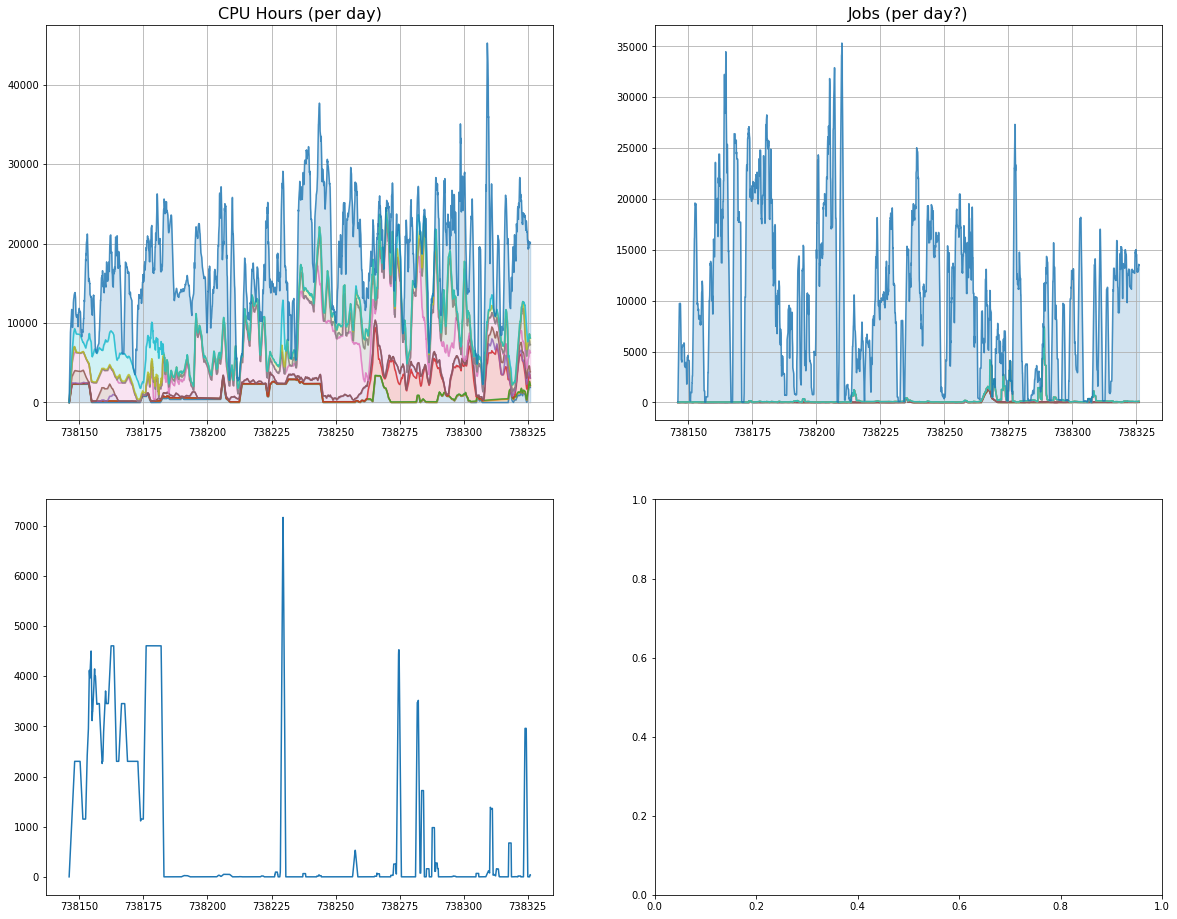

In [135]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('CPU Hours (per day)', size=16)
ax2.set_title('Jobs (per day?)', size=16)
#
cpuh = cpuh_layers['cpu_hours']
hpc_lib.plot_layer_cake(data=cpuh_layers['cpu_hours'], ax=ax1)
hpc_lib.plot_layer_cake(data=cpuh_layers['jobs'], ax=ax2)

ax3.plot(cpuh['time'], cpuh['tgp'])

In [31]:
NGPUS = [s.split('gpu=')[1].split(',')[0] if 'gpu=' in s else 0 
         for s in SACCT_obj.jobs_summary['AllocTRES'].astype(str)]

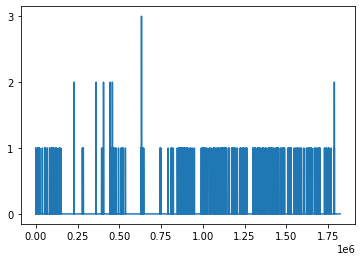

In [34]:
plt.plot(SACCT_obj.get_NGPUs())

### Mazama GPU activity

In [115]:
maz_h5 = 'sacct_data/sacct_pNONE_gNONE_uNone_20211222_20220620.h5'
SACCT_serc = SACCT_obj = hpc_lib.SACCT_data_from_h5(maz_h5, keep_raw_data=False, n_cpu=n_cpus)

# serc_gpu_activity = SACCT_serc.active_jobs_cpu(jobs_summary=None, bin_size=1., 
#                                                NCPUs=SACCT_serc.get_NGPUs())

In [117]:
gpu_layers = SACCT_serc.get_active_cpus_layer_cake(layer_field='Group', NCPUs=SACCT_serc.get_NGPUs())

/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:624: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if NCPUs is None or NCPUs=='':


*** DEBUG: 5000, None


** ['users: 380.2']
** vals:  [380.16340277777743]
*** keys():  dict_keys(['N_cpu', 'N_jobs'])


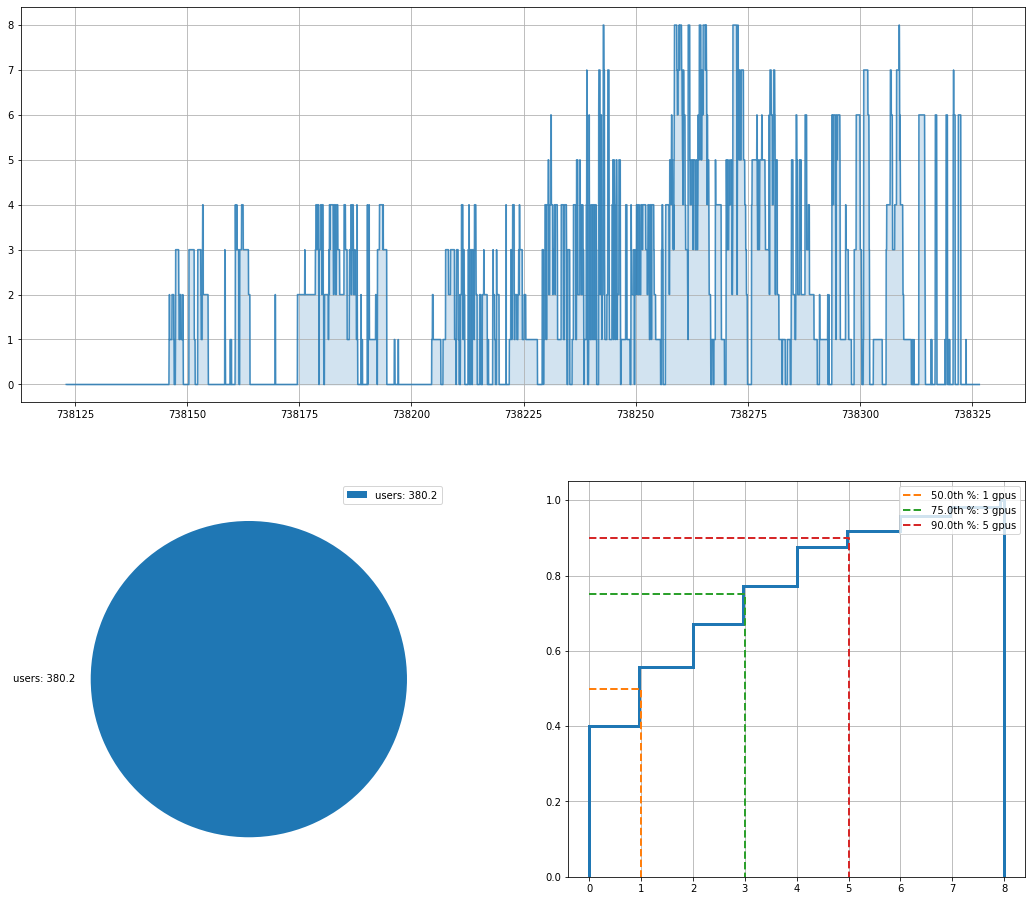

In [121]:
# For MAZAMA
#
pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
print(f'** {pi_gpu_lbls}' )
#
NGPU = SACCT_serc.get_NGPUs()
#
#pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
pi_gpu_vals = []
pi_gpu_lbls = []
for k,g in enumerate(pi_gpu_grps):
    ix = SACCT_serc.jobs_summary['Group'].astype(str)==g
    #
    n_gpus = numpy.sum(SACCT_serc.jobs_summary['Elapsed'][ix] * NGPU[ix])
    if n_gpus <= 0.:
        continue
    #
    pi_gpu_vals += [n_gpus]
    pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
#
print('** vals: ', pi_gpu_vals)
#pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,2,3)
ax3 = fg.add_subplot(2,2,4)
ax1.grid()
#ax2.grid()
ax3.grid()
#
hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
z_gpus = ax1.lines[-1].get_ydata()
qs = [.5, .75, .9]
qs_gpu = numpy.quantile(z_gpus, qs)
#
print('*** keys(): ', gpu_layers.keys())
ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
ax2.legend(loc=0)
#
hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_gpu, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

ax1.set_title('Active GPUs', size=16)
ax3.legend(loc=0)

### SERC GPU activity

In [128]:
serc_h5 = 'sacct_data/serc_sacct_20211126_20220525.h5'
SACCT_serc = hpc_lib.SACCT_data_from_h5(serc_h5, keep_raw_data=False, n_cpu=n_cpus)

serc_gpu_activity = SACCT_serc.active_jobs_cpu(jobs_summary=None, bin_size=1., 
                                               NCPUs=SACCT_serc.get_NGPUs())

*** DEBUG: 183, 1.0


In [129]:
gpu_layers = SACCT_serc.get_active_cpus_layer_cake(layer_field='Group', NCPUs=SACCT_serc.get_NGPUs())

*** DEBUG: 5000, None


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:624: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if NCPUs is None or NCPUs=='':


*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
** ** **: t_start, t_end:  [19048.34990741] [19050.21159722]
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None


** ['users: 380.2']
** vals:  [78.00482638888889, 1116.7903472222222, 0.1394675925925926, 0.2748842592592593, 2203.31869212963, 0.002870370370370371, 181.91452546296296, 327.7860648148148, 1.6576157407407408, 63.74034722222222, 12.820648148148148]
*** keys():  dict_keys(['N_cpu', 'N_jobs'])


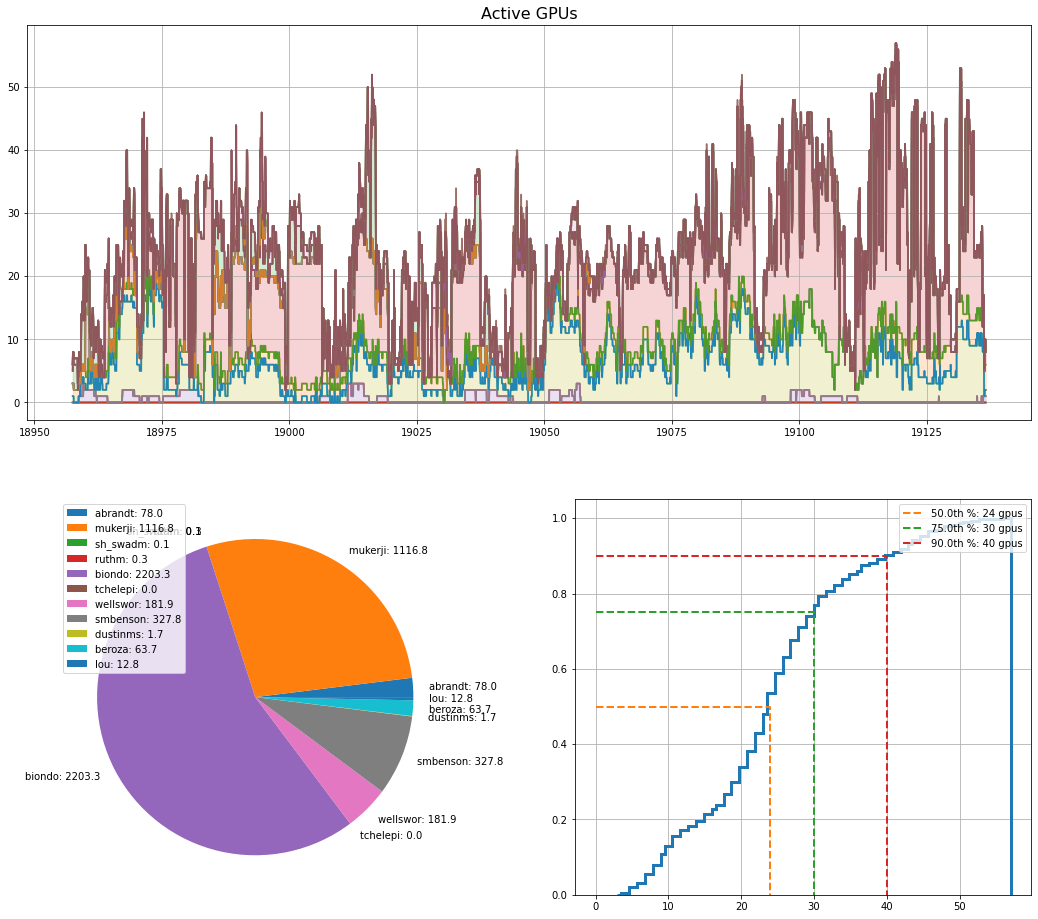

In [130]:
pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
print(f'** {pi_gpu_lbls}' )
#
NGPU = SACCT_serc.get_NGPUs()
#
#pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
pi_gpu_vals = []
pi_gpu_lbls = []
for k,g in enumerate(pi_gpu_grps):
    ix = SACCT_serc.jobs_summary['Group'].astype(str)==g
    #
    n_gpus = numpy.sum(SACCT_serc.jobs_summary['Elapsed'][ix] * NGPU[ix])
    if n_gpus <= 0.:
        continue
    #
    pi_gpu_vals += [n_gpus]
    pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
#
print('** vals: ', pi_gpu_vals)
#pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,2,3)
ax3 = fg.add_subplot(2,2,4)
ax1.grid()
#ax2.grid()
ax3.grid()
#
hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
z_gpus = ax1.lines[-1].get_ydata()
qs = [.5, .75, .9]
qs_gpu = numpy.quantile(z_gpus, qs)
#
print('*** keys(): ', gpu_layers.keys())
ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
ax2.legend(loc=0)
#
hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_gpu, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

ax1.set_title('Active GPUs', size=16)
ax3.legend(loc=0)


In [131]:
print('** ', gpu_layers['N_cpu'].dtype.names)

**  ('time', 'wmao', 'dtartako', 'leift', 'mlapotre', 'abrandt', 'hilley', 'jsuckale', 'omramom', 'mukerji', 'sklemp', 'edunham', 'sh_swadm', 'ruthm', 'biondo', 'rknight', 'sonori', 'robertj2', 'jhj1', 'kens', 'oneillm', 'tchelepi', 'gorelick', 'wellswor', 'dekas', 'jcaers', 'konings', 'smbenson', 'aditis2', 'dustinms', 'glucia', 'elambin', 'ibattiat', 'beroza', 'mburke', 'segall', 'lou')


In [132]:
cpu_jobs_serc = SACCT_serc.active_jobs_cpu()


*** DEBUG: 5000, None


In [133]:
serc_cpu_qs = numpy.quantile(cpu_jobs_serc['N_cpu'], [.5, .75, .9])
print('** qs: ', serc_cpu_qs)

** qs:  [2511.5 3336.5 4105.1]


<ipython-input-141-2d0f7349995f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls)


[Text(738125.0, 0, '2021-12-1'),
 Text(738150.0, 0, '2021-12-26'),
 Text(738175.0, 0, '2022-1-20'),
 Text(738200.0, 0, '2022-2-14'),
 Text(738225.0, 0, '2022-3-11'),
 Text(738250.0, 0, '2022-4-5'),
 Text(738275.0, 0, '2022-4-30'),
 Text(738300.0, 0, '2022-5-25'),
 Text(738325.0, 0, '2022-6-19'),
 Text(738350.0, 0, '2022-7-14')]

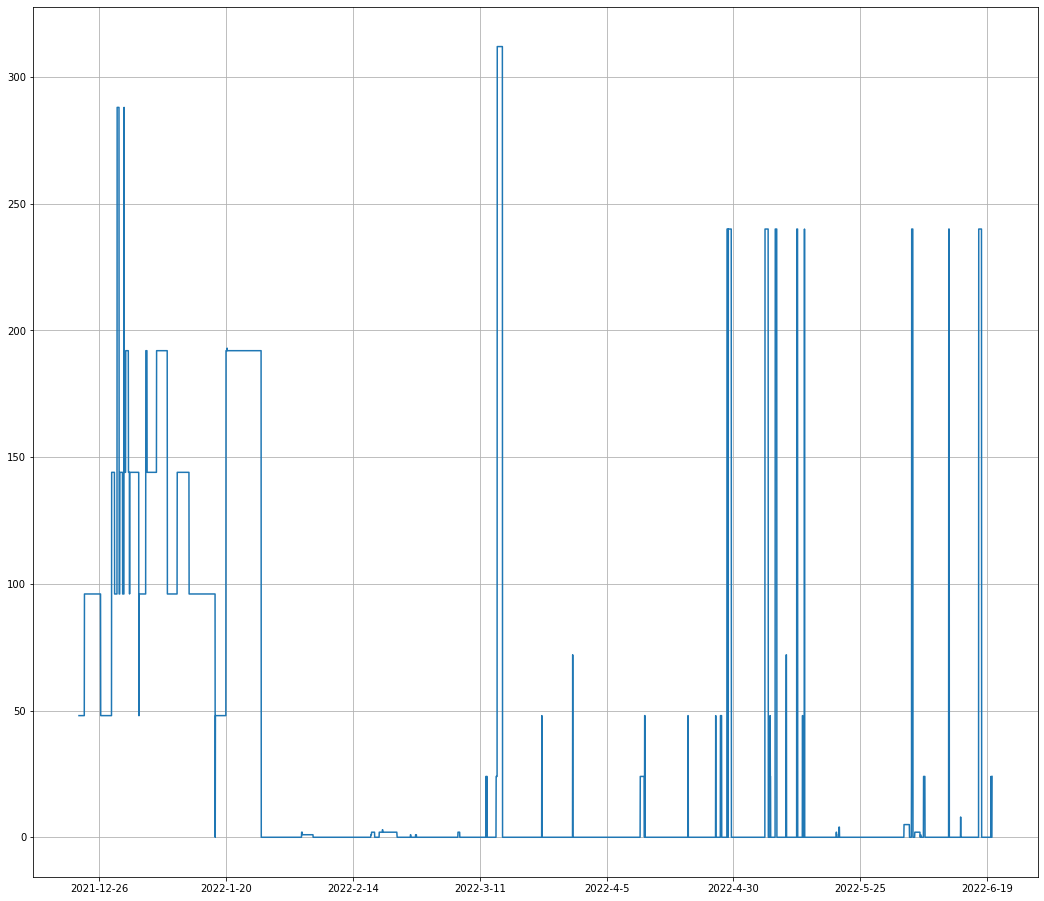

In [141]:
acpu = acpu_layer_cake['N_cpu']
fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(1,1,1)
#
ax1.grid()
ax1.plot(acpu['time'], acpu['tgp'])

fg.canvas.draw()
#lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) - hpc_lib.dt_mpd_epoch) ) 
#         for s in ax1.get_xticklabels()]
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) + SACCT_obj.dt_mpd_epoch) ) 
         for s in ax1.get_xticklabels()]
ax1.set_xticklabels(lbls)


In [214]:
print('*** ', SACCT_serc.jobs_summary.dtype)

***  [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('JobName', 'S81'), ('JobID', 'S67'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S48'), ('AllocTRES', 'S61'), ('JobID_parent', 'S67')]


In [228]:
print('*** ', hpc_lib.kmg_to_num('105k'))
print('** ', [hpc_lib.kmg_to_num(s) for s in ['11k', '11m', '11M', '11g']])
print('** ', [hpc_lib.kmg_to_num(s) for s in ['11', '11.3', '', 's']])

***  105000.0
**  [11000.0, 11000000.0, 11000000.0, 11000000000.0]
**  [11.0, 11.3, None, None]


In [13]:
print('** ', SACCT_obj.jobs_summary.dtype.names)

**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent')


**  0


ValueError: autodetected range of [nan, nan] is not finite

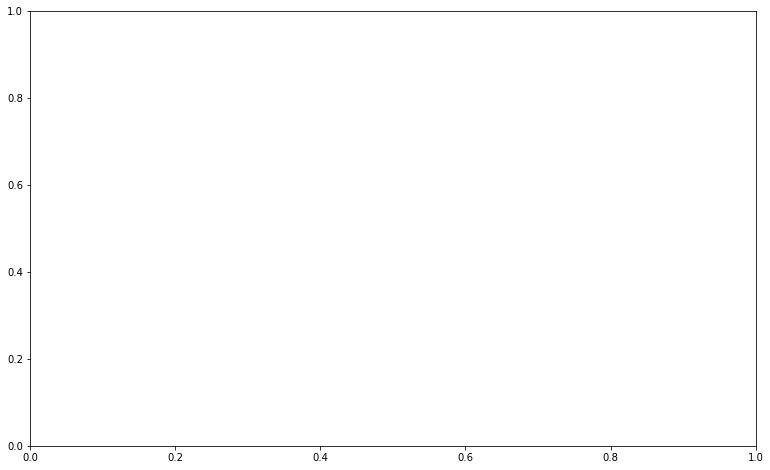

In [22]:
fg = plt.figure(figsize=(13,8))
ax = fg.add_subplot(1,1,1)
#
print('** ', numpy.sum([not numpy.isnan(x) for x in SACCT_obj.jobs_summary['MaxRSS']]))
hh = ax.hist(SACCT_obj.jobs_summary['MaxRSS'], bins=100, histtype='step', cumulative=True)

In [229]:
os.system('hostname')

0

In [230]:
import socket
socket.gethostname()

'UIT-C02YT0LBLVDP.local'